In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [4]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import HuberRegressor, QuantileRegressor

from gallifrey.model import Model
from gallifrey.utilities.dataframe import aggregated_dataframe, rename_labels
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
)

## DATA SETUP

In [5]:
snapshot = 127
resolution = 8192
sim_id = "37_11"

In [6]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo

yt : [INFO     ] 2023-11-08 15:44:51,782 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-11-08 15:44:51,957 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-11-08 15:44:51,958 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-08 15:44:51,959 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-08 15:44:51,960 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-11-08 15:44:51,961 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-08 15:44:51,962 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-11-08 15:44:51,962 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-11-08 15:44:51,963 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-11-08 15:44:51,965 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-11-08 15:44:51,966 Parameters: hubble_constant      

## PLOT SETUP

In [7]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Galaxy_properties"

## CREATE DATA SOURCE

In [8]:
radius = 0.2 * mw.virial_radius()
sphere_data = mw.sphere(radius=radius)

## GENERAL PROPERTIES

In [9]:
print(
    "Total Stellar Mass : {:.2f} * 10^10 Msun".format(
        np.sum(sphere_data["stars", "Masses"].to("Msun")).value / 1e10
    )
)

Total Stellar Mass : 5.87 * 10^10 Msun


## METALLICITY GRADIENT

In [10]:
data = pd.DataFrame(
    np.c_[
        sphere_data["thin_disk_stars", "particle_radius"].to("kpc"),
        sphere_data["thin_disk_stars", "[Fe/H]"],
        sphere_data["thin_disk_stars", "total_number"],
    ],
    columns=["Distance (kpc)", "[Fe/H]", "Total Number"],
)

In [20]:
fit_range = (0, 10)
data_range = data[data["Distance (kpc)"].between(*fit_range)]

regressor = HuberRegressor().fit(
    np.c_[data_range["Distance (kpc)"], np.ones_like(data_range["Distance (kpc)"])],
    data_range["[Fe/H]"],
    sample_weight=data_range["Total Number"],
)
print(f"Metallicity Gradient: {regressor.coef_[0]} dex/kpc")

(-5.0, 1.0)

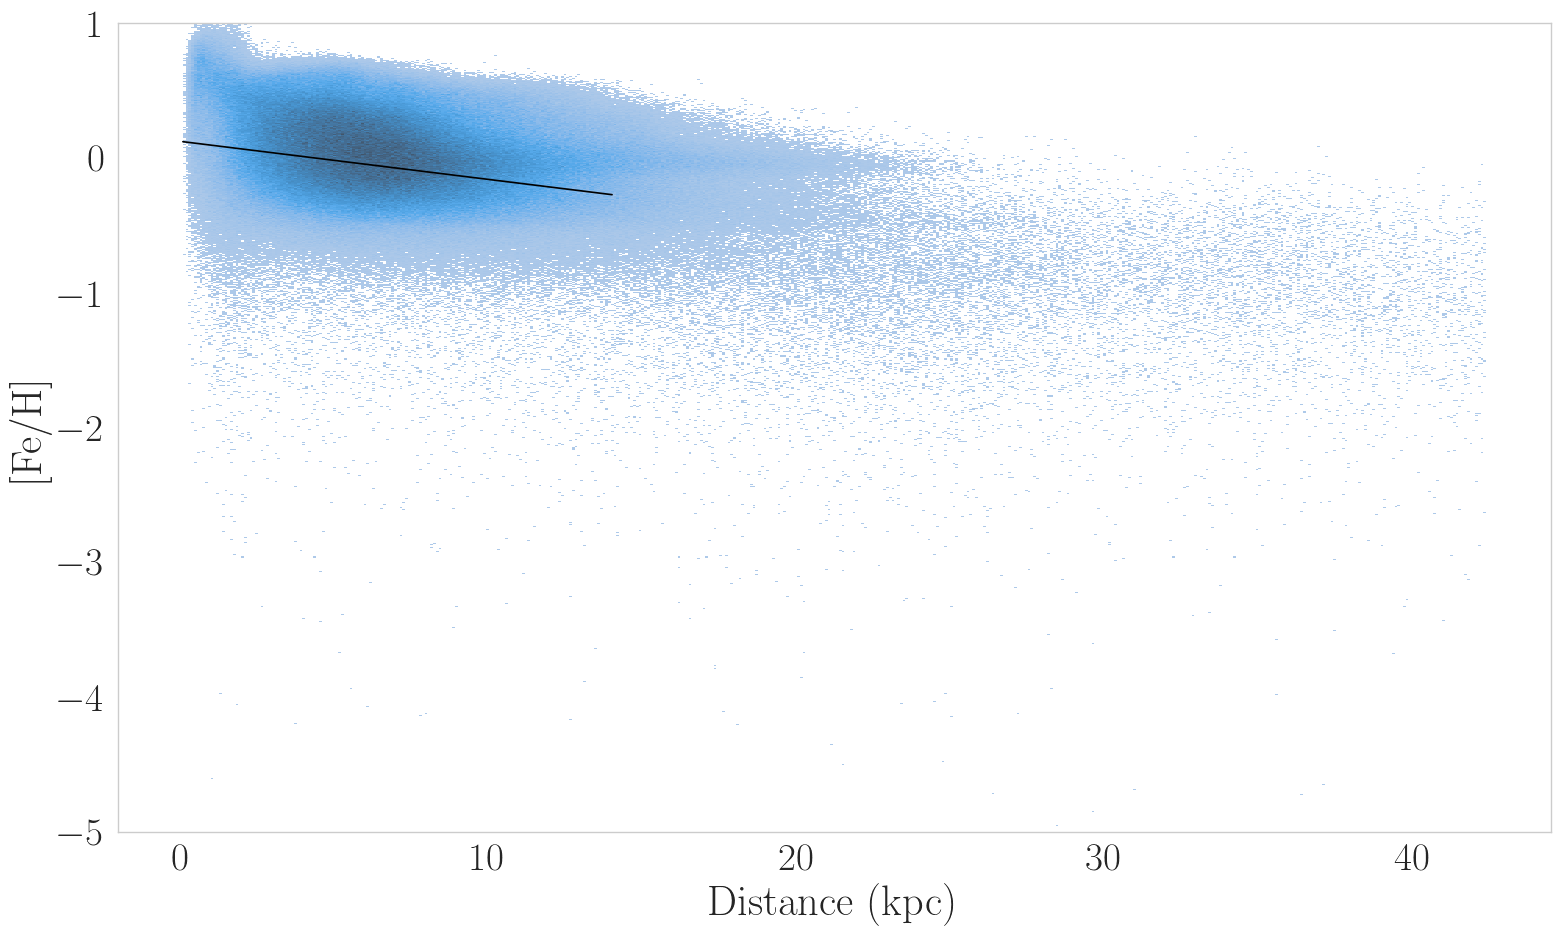

In [ ]:
x = np.linspace(
    data_range["Distance (kpc)"].min(), data_range["Distance (kpc)"].max(), 100
)

sns.histplot(x=data["Distance (kpc)"], y=data["[Fe/H]"])
plt.plot(x, regressor.coef_[0] * x + regressor.coef_[1], color="black")
plt.ylim(-5, 1)